In [1]:
import torch 
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sklearn
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn.metrics import r2_score
from sklearn import preprocessing
from numpy.random import seed
import joblib

#Reproducability of Results
seed(1)
torch.cuda.manual_seed(1)

#GPU init
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Number of GPU(s): {}".format(torch.cuda.device_count()))

Number of GPU(s): 1


In [2]:
# Training and Testing Dataset

data_no_tx = pd.read_csv('Dataset/data_no_tx.csv')
data_tx = pd.read_csv('Dataset/data_tx.csv')

label_enc_tx = preprocessing.MinMaxScaler(feature_range=(0,1))
label_enc_no_tx = preprocessing.MinMaxScaler(feature_range=(0,1))

# data_tx_cols = data_tx.columns 
# data_no_tx_cols = data_no_tx.columns

# dataset_tx = label_enc_tx.fit_transform(data_tx.values)
# dataset_no_tx = label_enc_no_tx.fit_transform(data_no_tx.values)

# data_tx = pd.DataFrame(dataset_tx,columns=data_tx_cols)
# data_no_tx = pd.DataFrame(dataset_no_tx,columns=data_no_tx_cols)

y_tx = data_tx[['energyConsumption','Throughput','ms']]
y_tx.energyConsumption = y_tx.energyConsumption.round(2).astype(int)
y_tx.Throughput = y_tx.Throughput.round(2).astype(int)
y_tx.ms = y_tx.ms.round(2).astype(int)

data_tx.drop(columns=['energyConsumption','Throughput','ms'],axis=0,inplace=True)
x_tx = data_tx

y_no_tx = data_no_tx[['energyConsumption','ms']]
y_no_tx.energyConsumption = y_no_tx.energyConsumption.round(2).astype(int)
y_no_tx.ms = y_no_tx.ms.round(2).astype(int)
data_no_tx.drop(columns=['energyConsumption','ms'],axis=0,inplace=True)
x_no_tx = data_no_tx

train_x_tx,test_x_tx,train_y_tx,test_y_tx = train_test_split(x_tx.values,y_tx.values,test_size=0.3)
train_x_no_tx,test_x_no_tx,train_y_no_tx,test_y_no_tx = train_test_split(x_no_tx.values,y_no_tx.values,test_size=0.3)

train_x_tx = label_enc_tx.fit_transform(train_x_tx)
test_x_tx = label_enc_tx.transform(test_x_tx)

train_x_no_tx = label_enc_no_tx.fit_transform(train_x_no_tx)
test_x_no_tx = label_enc_no_tx.transform(test_x_no_tx)

train_y_tx = label_enc_tx.fit_transform(train_y_tx)
test_y_tx = label_enc_tx.transform(test_y_tx)

train_y_no_tx = label_enc_no_tx.fit_transform(train_y_no_tx)
test_y_no_tx = label_enc_no_tx.transform(test_y_no_tx)

joblib.dump(label_enc_no_tx, 'Models/label_enc_no_tx.save') 
joblib.dump(label_enc_tx, 'Models/label_enc_tx.save') 

x_tx_cols = x_tx.columns
x_no_tx_cols = x_no_tx.columns
y_tx_cols = y_tx.columns
y_no_tx_cols = y_no_tx.columns

train_x_tx = pd.DataFrame(train_x_tx,columns=x_tx_cols)
test_x_tx = pd.DataFrame(test_x_tx,columns=x_tx_cols)
train_x_no_tx = pd.DataFrame(train_x_no_tx,columns=x_no_tx_cols)
test_x_no_tx = pd.DataFrame(test_x_no_tx,columns=x_no_tx_cols)

train_y_tx = pd.DataFrame(train_y_tx,columns=y_tx_cols)
test_y_tx = pd.DataFrame(test_y_tx,columns=y_tx_cols)
train_y_no_tx = pd.DataFrame(train_y_no_tx,columns=y_no_tx_cols)
test_y_no_tx = pd.DataFrame(test_y_no_tx,columns=y_no_tx_cols)

train_x_tx.shape,train_y_tx.shape,train_x_no_tx.shape,train_y_no_tx.shape,test_x_tx.shape,test_y_tx.shape,test_x_no_tx.shape,test_y_no_tx.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


((480, 10),
 (480, 3),
 (6815, 8),
 (6815, 2),
 (207, 10),
 (207, 3),
 (2922, 8),
 (2922, 2))

In [3]:
# Hyper Parameters for DNN

def get_hyper_parameters(with_tx):
    if with_tx:
        number_of_inputs = train_x_tx.shape[1]
        number_of_outputs = train_y_tx.shape[1]
    else:
        number_of_inputs = train_x_no_tx.shape[1]
        number_of_outputs = train_y_no_tx.shape[1]
    return number_of_inputs,number_of_outputs

hidden_layer_size = 64
learning_rate = 0.000005
number_of_epochs = 100000 # N.B - use this or convergence method


In [4]:
class DNNRegression(torch.nn.Module):
    
    def __init__(self,number_of_inputs,hidden_layer_size,number_of_outputs):
        super(DNNRegression, self).__init__()
        self.hidden = torch.nn.Linear(number_of_inputs,hidden_layer_size)
        self.hidden2 = torch.nn.Linear(hidden_layer_size,128)
        self.hidden3 = torch.nn.Linear(128,256)
        self.hidden4 = torch.nn.Linear(256,512)
        self.predict = torch.nn.Linear(512,number_of_outputs)
        
    def forward(self,x):
        x = F.relu(self.hidden(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = F.relu(self.predict(x))
        return x

In [5]:
# Model Testing with r2 score

def Test_Model(model,test_x,test_y):
    with torch.no_grad():
        y_pred = model(test_x.to(device))
        r2 = round(r2_score(test_y, y_pred.cpu().numpy()) * 100,2)
    return r2

In [6]:
# Model Training

def Train_Model(number_of_epochs,number_of_inputs,hidden_layer_size,number_of_outputs,train_x,train_y,test_x,test_y,with_tx):
    
    if with_tx:
        tx = 'tx'
    else:
        tx = 'no_tx'
    
    max_acc = 0
    
    loss_history = list()
    score_history = list()
    training_accuracy = list()
    
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(DNNRegression(number_of_inputs,hidden_layer_size,number_of_outputs).to(device))
    else:
        model = DNNRegression(number_of_inputs,hidden_layer_size,number_of_outputs).to(device)

    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = torch.nn.MSELoss()

    for iteration in range(number_of_epochs):

        prediction = model(train_x.to(device))
        loss = loss_function(prediction,train_y.to(device))
        loss.backward()
        optimiser.step()

        loss_history.append(loss.item())
        
        score = Test_Model(model,test_x,test_y)
        
        score = score if score >= 0 else 0
        score_history.append(score)
        
        if score > max_acc:
            torch.save(model.state_dict(), 'Models/model_{}.pt'.format(tx))
        
        training_score = Test_Model(model,train_x,train_y)
        
        training_score = training_score if training_score >= 0 else 0
        
        training_accuracy.append(training_score)

        if iteration % 1000 == 0:
            print("Iteration Number [{}/{}], Loss {:.5f}, Train Dataset Accuracy: {}, Test Dataset Accuracy: {}".format(iteration,number_of_epochs,loss.item(),training_score,score))       
    
    #save loss_history as csv
    pd.DataFrame(loss_history).to_csv('Models/loss_history_{}.csv'.format(tx), index=False)
    #save training_accuracy as csv
    pd.DataFrame(training_accuracy).to_csv('Models/trainig_accuracy_{}.csv'.format(tx), index=False)
    #save testing_accuracy as csv
    pd.DataFrame(score_history).to_csv('Models/testing_accuracy_{}.csv'.format(tx), index=False)
    
    plt.figure(1,figsize=(16,7))
    plt.subplot(1,2,1)
    plt.scatter(range(len(loss_history)),loss_history,label="Training Loss")
    plt.legend(loc="upper left")
    plt.plot()
    
    plt.subplot(1,2,2)
    plt.scatter(range(len(score_history)),score_history,label="Testing Accuracy",color='r',marker='.')
    plt.scatter(range(len(training_accuracy)),training_accuracy,label="Training Accuracy",color='b',marker='.')
    plt.legend(loc="upper left")
    plt.plot()
    plt.show()
    
    print("Min Loss: {} at iteration: {}, Max R2 Score: {}".format(min(loss_history),loss_history.index(min(loss_history)),max(score_history)))

Iteration Number [0/100000], Loss 0.02016, Train Dataset Accuracy: 0, Test Dataset Accuracy: 0
Iteration Number [1000/100000], Loss 0.01101, Train Dataset Accuracy: 0, Test Dataset Accuracy: 0
Iteration Number [2000/100000], Loss 0.00982, Train Dataset Accuracy: 0, Test Dataset Accuracy: 0
Iteration Number [3000/100000], Loss 0.00911, Train Dataset Accuracy: 12.98, Test Dataset Accuracy: 1.98
Iteration Number [4000/100000], Loss 0.00376, Train Dataset Accuracy: 57.89, Test Dataset Accuracy: 43.58
Iteration Number [5000/100000], Loss 0.00212, Train Dataset Accuracy: 73.86, Test Dataset Accuracy: 65.14
Iteration Number [6000/100000], Loss 0.00168, Train Dataset Accuracy: 79.62, Test Dataset Accuracy: 68.22
Iteration Number [7000/100000], Loss 0.00146, Train Dataset Accuracy: 82.3, Test Dataset Accuracy: 73.13
Iteration Number [8000/100000], Loss 0.00137, Train Dataset Accuracy: 83.24, Test Dataset Accuracy: 74.24
Iteration Number [9000/100000], Loss 0.00128, Train Dataset Accuracy: 84.21

Iteration Number [78000/100000], Loss 0.00087, Train Dataset Accuracy: 90.78, Test Dataset Accuracy: 69.07
Iteration Number [79000/100000], Loss 0.00097, Train Dataset Accuracy: 90.15, Test Dataset Accuracy: 64.84
Iteration Number [80000/100000], Loss 0.00085, Train Dataset Accuracy: 91.2, Test Dataset Accuracy: 62.11
Iteration Number [81000/100000], Loss 0.00091, Train Dataset Accuracy: 90.64, Test Dataset Accuracy: 59.77
Iteration Number [82000/100000], Loss 0.00084, Train Dataset Accuracy: 91.11, Test Dataset Accuracy: 59.03
Iteration Number [83000/100000], Loss 0.00080, Train Dataset Accuracy: 91.77, Test Dataset Accuracy: 60.2
Iteration Number [84000/100000], Loss 0.00081, Train Dataset Accuracy: 91.41, Test Dataset Accuracy: 61.26
Iteration Number [85000/100000], Loss 0.00082, Train Dataset Accuracy: 91.48, Test Dataset Accuracy: 61.26
Iteration Number [86000/100000], Loss 0.00081, Train Dataset Accuracy: 91.44, Test Dataset Accuracy: 61.91
Iteration Number [87000/100000], Loss 0

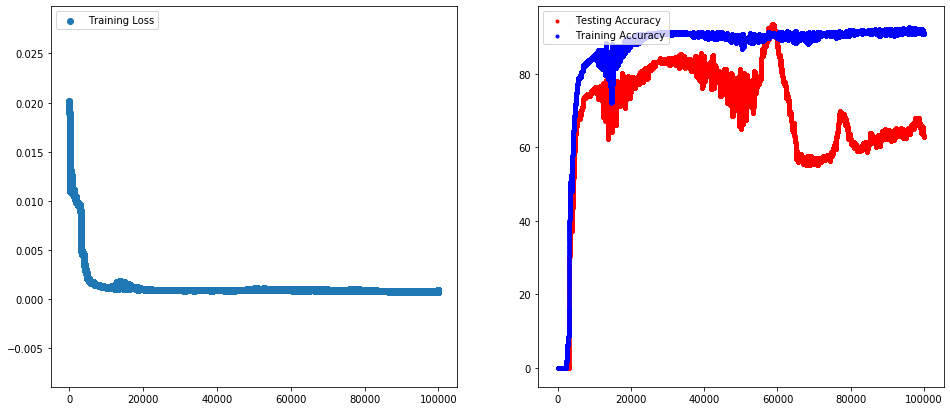

Min Loss: 0.0007165289716795087 at iteration: 95959, Max R2 Score: 93.61


In [7]:
#Train Model w/ Data Tx
number_of_inputs,number_of_outputs = get_hyper_parameters(with_tx=True)
Train_Model(number_of_epochs,number_of_inputs,hidden_layer_size,number_of_outputs,torch.Tensor(train_x_tx.values),torch.Tensor(train_y_tx.values),torch.Tensor(test_x_tx.values),torch.Tensor(test_y_tx.values),with_tx=True)

Iteration Number [0/100000], Loss 0.00438, Train Dataset Accuracy: 0, Test Dataset Accuracy: 0
Iteration Number [1000/100000], Loss 0.00172, Train Dataset Accuracy: 38.64, Test Dataset Accuracy: 39.38
Iteration Number [2000/100000], Loss 0.00155, Train Dataset Accuracy: 41.48, Test Dataset Accuracy: 42.78
Iteration Number [3000/100000], Loss 0.00170, Train Dataset Accuracy: 38.72, Test Dataset Accuracy: 39.96
Iteration Number [4000/100000], Loss 0.00235, Train Dataset Accuracy: 27.8, Test Dataset Accuracy: 27.65
Iteration Number [5000/100000], Loss 0.00199, Train Dataset Accuracy: 34.06, Test Dataset Accuracy: 34.69
Iteration Number [6000/100000], Loss 0.00047, Train Dataset Accuracy: 83.75, Test Dataset Accuracy: 87.88
Iteration Number [7000/100000], Loss 0.00034, Train Dataset Accuracy: 89.04, Test Dataset Accuracy: 93.38
Iteration Number [8000/100000], Loss 0.00026, Train Dataset Accuracy: 92.82, Test Dataset Accuracy: 97.25
Iteration Number [9000/100000], Loss 0.00030, Train Datase

Iteration Number [77000/100000], Loss 0.00016, Train Dataset Accuracy: 95.94, Test Dataset Accuracy: 98.8
Iteration Number [78000/100000], Loss 0.00016, Train Dataset Accuracy: 95.92, Test Dataset Accuracy: 98.91
Iteration Number [79000/100000], Loss 0.00017, Train Dataset Accuracy: 95.47, Test Dataset Accuracy: 98.35
Iteration Number [80000/100000], Loss 0.00015, Train Dataset Accuracy: 96.09, Test Dataset Accuracy: 98.91
Iteration Number [81000/100000], Loss 0.00015, Train Dataset Accuracy: 96.0, Test Dataset Accuracy: 98.63
Iteration Number [82000/100000], Loss 0.00017, Train Dataset Accuracy: 95.67, Test Dataset Accuracy: 98.32
Iteration Number [83000/100000], Loss 0.00016, Train Dataset Accuracy: 95.89, Test Dataset Accuracy: 98.8
Iteration Number [84000/100000], Loss 0.00015, Train Dataset Accuracy: 96.01, Test Dataset Accuracy: 99.06
Iteration Number [85000/100000], Loss 0.00016, Train Dataset Accuracy: 95.9, Test Dataset Accuracy: 98.92
Iteration Number [86000/100000], Loss 0.0

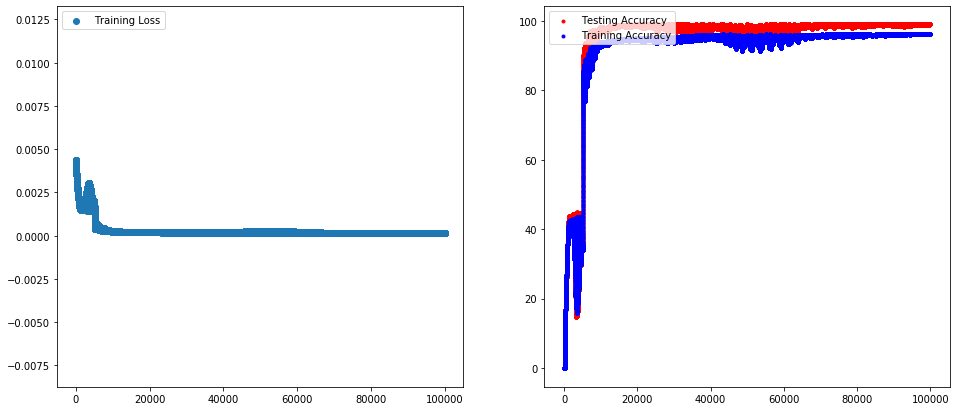

Min Loss: 0.00014383794041350484 at iteration: 99364, Max R2 Score: 99.19


In [8]:
#Train Model w/ Data No Tx
number_of_inputs,number_of_outputs = get_hyper_parameters(with_tx=False)
Train_Model(number_of_epochs,number_of_inputs,hidden_layer_size,number_of_outputs,torch.Tensor(train_x_no_tx.values),torch.Tensor(train_y_no_tx.values),torch.Tensor(test_x_no_tx.values),torch.Tensor(test_y_no_tx.values),with_tx=False)